In [1]:
import os
import wget
from pathlib import Path
# 데이터 수집 URL
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
# 데이터셋 명
dataset_name = 'census-income'
# 데이터 저장 경로 생성
out = Path(os.getcwd() + '/data/' + dataset_name + '.csv')
out.parent.mkdir(parents = True, exist_ok = True)
if out.exists(): print("File already exists.")
else:
    print("Downloading file...")
    # 데이터 다운로드
    wget.download(url, out.as_posix())

File already exists.


In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
# 데이터 불러오기
train = pd.read_csv(out).copy()
target = ' <=50K'
# 학습/검증/평가 데이터 구분
if "Set" not in train.columns: train["Set"] = np.random.choice(["train", "valid", "test"], p = [.8, .1, .1], size = (train.shape[0], ))
train_indices = train[train.Set == "train"].index
valid_indices = train[train.Set == "valid"].index
test_indices  = train[train.Set == "test" ].index
# 컬럼별 unique 개수
nunique = train.nunique()
# 컬럼별 dtype
types = train.dtypes
categorical_columns = []
categorical_dims =  {}
for col in train.columns:
    # 범주형 변수면 결측을 VV_likely로 채우고 라벨 인코딩 적용
    if types[col] == 'object' or nunique[col] < 200:
        l_enc = LabelEncoder()
        train[col] = train[col].fillna("VV_likely")
        train[col] = l_enc.fit_transform(train[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
        print(col, train[col].nunique(), l_enc.classes_)
    # 범주형 변수 아니면 결측을 평균으로 보완
    else: train.fillna(train.loc[train_indices, col].mean(), inplace = True)

39 73 [17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40
 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64
 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88
 90]
 State-gov 9 [' ?' ' Federal-gov' ' Local-gov' ' Never-worked' ' Private'
 ' Self-emp-inc' ' Self-emp-not-inc' ' State-gov' ' Without-pay']
 Bachelors 16 [' 10th' ' 11th' ' 12th' ' 1st-4th' ' 5th-6th' ' 7th-8th' ' 9th'
 ' Assoc-acdm' ' Assoc-voc' ' Bachelors' ' Doctorate' ' HS-grad'
 ' Masters' ' Preschool' ' Prof-school' ' Some-college']
 13 16 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
 Never-married 7 [' Divorced' ' Married-AF-spouse' ' Married-civ-spouse'
 ' Married-spouse-absent' ' Never-married' ' Separated' ' Widowed']
 Adm-clerical 15 [' ?' ' Adm-clerical' ' Armed-Forces' ' Craft-repair' ' Exec-managerial'
 ' Farming-fishing' ' Handlers-cleaners' ' Machine-op-inspct'
 ' Other-service' ' Priv-house-serv' ' Prof-specialty' ' Protective-serv'
 ' Sa

In [3]:
# 타겟 라벨 변경
train.loc[train[target] == 0, target] = "not_wealthy"
train.loc[train[target] == 1, target] = "wealthy"

In [4]:
import torch
from pytorch_tabnet.tab_model import TabNetClassifier
# 입력 변수
unused_feat = ['Set']
features = [col for col in train.columns if col not in unused_feat + [target]] 
# 범주형 변수
cat_idxs = [i for i, f in enumerate(features) if f in categorical_columns]
cat_dims = [categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]
# TabNet 임베딩 파라미터 설정
tabnet_params = {"cat_idxs" : cat_idxs,
                 "cat_dims" : cat_dims,
                 "cat_emb_dim" : 1,
                 "optimizer_fn" : torch.optim.Adam,
                 "optimizer_params" : {"lr" : 2e-2},
                 "scheduler_params":{"step_size" : 50, # how to use learning rate scheduler
                                     "gamma" : 0.9},
                 "scheduler_fn" : torch.optim.lr_scheduler.StepLR,
                 "mask_type" : 'entmax' # "sparsemax"
                }

Device used : cpu


In [7]:
# 인스턴스 생성
clf = TabNetClassifier(**tabnet_params)
# 학습 데이터
X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]
# 검증 데이터
X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]
# 평가 데이터
X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]
# epoch 설정
max_epochs = 100 if not os.getenv("CI", False) else 2
# 훈련 (warm start = False)
save_history = []
for _ in range(2):
    clf.fit(
            X_train = X_train, y_train = y_train,
            eval_set = [(X_train, y_train), (X_valid, y_valid)], eval_name = ['train', 'valid'], eval_metric = ['auc'],
            max_epochs = max_epochs, patience = 20,
            batch_size = 1024, virtual_batch_size = 128,
            num_workers = 0, weights = 1, drop_last = False
            )
    save_history.append(clf.history["valid_auc"])
assert(np.all(np.array(save_history[0] == np.array(save_history[1]))))

Device used : cpu
epoch 0  | loss: 0.67102 | train_auc: 0.75518 | valid_auc: 0.76232 |  0:00:03s
epoch 1  | loss: 0.52215 | train_auc: 0.81715 | valid_auc: 0.82345 |  0:00:05s
epoch 2  | loss: 0.45838 | train_auc: 0.86456 | valid_auc: 0.86898 |  0:00:08s
epoch 3  | loss: 0.42507 | train_auc: 0.88069 | valid_auc: 0.88324 |  0:00:11s
epoch 4  | loss: 0.40282 | train_auc: 0.89924 | valid_auc: 0.89831 |  0:00:13s
epoch 5  | loss: 0.38769 | train_auc: 0.90652 | valid_auc: 0.90391 |  0:00:16s
epoch 6  | loss: 0.38419 | train_auc: 0.90932 | valid_auc: 0.90724 |  0:00:18s
epoch 7  | loss: 0.37108 | train_auc: 0.90719 | valid_auc: 0.90391 |  0:00:20s
epoch 8  | loss: 0.36281 | train_auc: 0.89893 | valid_auc: 0.89606 |  0:00:23s
epoch 9  | loss: 0.35991 | train_auc: 0.9115  | valid_auc: 0.9095  |  0:00:27s
epoch 10 | loss: 0.35248 | train_auc: 0.91648 | valid_auc: 0.91494 |  0:00:29s
epoch 11 | loss: 0.35007 | train_auc: 0.92559 | valid_auc: 0.9205  |  0:00:32s
epoch 12 | loss: 0.34813 | train_a

<ipython-input-7-9aaceec6493e>:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  assert(np.all(np.array(save_history[0] == np.array(save_history[1]))))


AssertionError: 

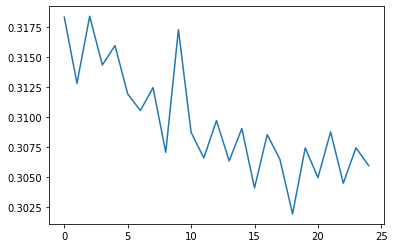

In [9]:
import matplotlib.pyplot as plt
# loss 시각화
plt.plot(clf.history['loss'])
plt.show()

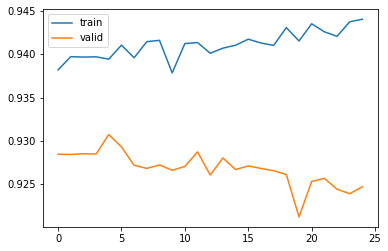

In [13]:
# AUC 시각화
plt.plot(clf.history['train_auc'], label = 'train')
plt.plot(clf.history['valid_auc'], label = 'valid')
plt.legend()
plt.show()

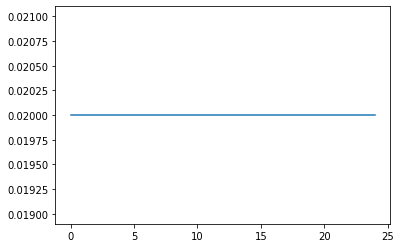

In [14]:
# 학습률 시각화
plt.plot(clf.history['lr'])
plt.show()

In [29]:
from sklearn.metrics import roc_auc_score
# 검증 데이터 예측
preds_valid = clf.predict_proba(X_valid)
valid_auc = roc_auc_score(y_score = preds_valid[:, 1], y_true = y_valid)
# 평가 데이터 예측
preds = clf.predict_proba(X_test)
test_auc = roc_auc_score(y_score = preds[:, 1], y_true = y_test)
print(f"FINAL VALID SCORE FOR {dataset_name} : {valid_auc}")
print(f"FINAL TEST SCORE FOR {dataset_name} : {test_auc}")
# 최적 가중치가 적용되었는지 확인
assert np.isclose(valid_auc, np.max(clf.history['valid_auc']), atol = 1e-6)
# 평가 데이터 예측 결과
clf.predict(X_test)

FINAL VALID SCORE FOR census-income : 0.9307252768096355
FINAL TEST SCORE FOR census-income : 0.9218517434924386


array(['wealthy', 'not_wealthy', 'wealthy', ..., 'not_wealthy',
       'not_wealthy', 'not_wealthy'], dtype='<U11')

In [30]:
# TabNet 저장
saving_path_name = "./example_binary_classification"
saved_filepath = clf.save_model(saving_path_name)

Successfully saved model at ./example_binary_classification.zip


In [31]:
# TabNet 불러오기
loaded_clf = TabNetClassifier()
loaded_clf.load_model(saved_filepath)
print(saved_filepath)

Device used : cpu
Device used : cpu
./example_binary_classification.zip


In [32]:
# 불러온 TabNet으로 평가 데이터 예측
loaded_preds = loaded_clf.predict_proba(X_test)
loaded_test_auc = roc_auc_score(y_score = loaded_preds[:, 1], y_true = y_test)
print(f"FINAL TEST SCORE FOR {dataset_name} : {loaded_test_auc}")
assert(test_auc == loaded_test_auc)
# 평가 데이터 예측 결과
loaded_clf.predict(X_test)

FINAL TEST SCORE FOR census-income : 0.9218517434924386


array(['wealthy', 'not_wealthy', 'wealthy', ..., 'not_wealthy',
       'not_wealthy', 'not_wealthy'], dtype='<U11')

In [33]:
# Global Explainability
clf.feature_importances_

array([3.05440369e-05, 1.58607595e-02, 4.50564568e-02, 8.97874887e-02,
       7.67481941e-02, 1.13819458e-01, 9.46281244e-02, 3.34947149e-02,
       1.19538244e-02, 5.16385165e-02, 3.42973310e-01, 7.99365502e-02,
       4.37017813e-02, 3.70276914e-04])

Shape of explain_matrix:  (3337, 14)
Keys of masks:  dict_keys([0, 1, 2])
Shape of masks[0]:  (3337, 14)


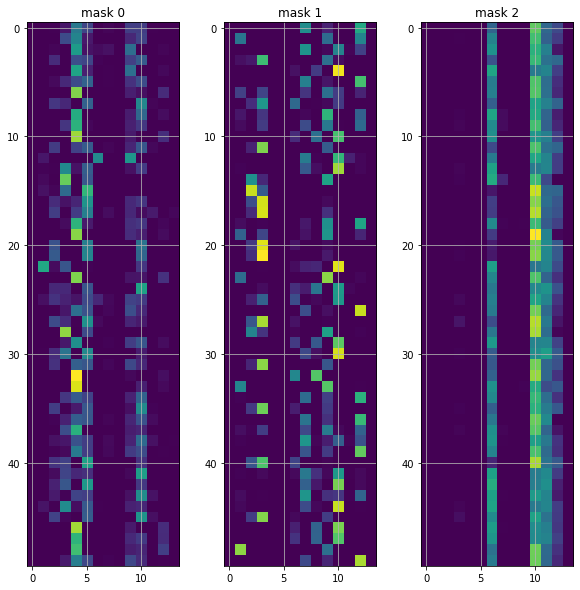

In [46]:
# Local Explainability와 Masks
explain_matrix, masks = clf.explain(X_test)
print("Shape of explain_matrix: ", explain_matrix.shape)
print("Keys of masks: ", masks.keys())
print("Shape of masks[0]: ", masks[0].shape)
# Masks 시각화
fig, axs = plt.subplots(1, 3, figsize = (10, 10))
for i in range(3):
    axs[i].imshow(masks[i][: 50])
    axs[i].set_title(f"mask {i}")
    axs[i].grid()
plt.show()